In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('A1_data/BondPrices.csv')

In [4]:
dates = ['Date', 'Issue', 'Maturity']
data[dates] = data[dates].astype('datetime64[ns]')
data = data.set_index('Date')

In [5]:
valid_dates = []
month_years = [(3,2020), (9,2020), (3,2021), (9,2021), (3,2022), (6,2022), (3,2023), (6,2023), (3,2024), (9,2024)]
for m,y in month_years:
    valid_dates.append(datetime.datetime(y, m, 1))
bonds = data[(data['Maturity'].isin(valid_dates)) & (data['Coupon'] < 4.0)]

In [6]:
from itertools import chain
curve_dates = []
for d in chain(range(2,4), range(6,11), range(13,16)): # Jan 2-15
        curve_dates.append(datetime.datetime(2020, 1, d))

In [7]:
from scipy.optimize import fsolve

PAR = 100
def get_yield(price, coupon, T):
    func = lambda r: coupon*(1+r)**T - coupon +PAR*r-price*r*(1+r)**T
    res = fsolve(func,1)
    return res

In [8]:
times = [0.25, 0.75, 1.25, 1.75, 2.25, 2.5, 3.25, 3.5, 4.25,4.75]
def get_spot_rate(prices,coupons):
    yields = [-np.log(prices[0]/PAR)/times[0]]
    for i in range(1,len(times)):
        t = times[i]
        s = 0
        for j,y in enumerate(yields):
            s += coupons[i]*np.exp(-y*times[j]) # coupon[i] since we want to use the current bonds coupon
        y = -np.log((prices[i]-s)/(PAR+coupons[i]))/t
        yields.append(y)
    return yields

def get_spot_rate2(prices,coupons):
    yields = [PAR/prices[0]-1]
    for i in range(1,len(times)):
        t = times[i]
        #print('\nNEXT')
        s = 0
        for j,y in enumerate(yields):
            s += coupons[i]/((1+y)**times[j]) # coupon[i] since we want to use the current bond's coupon
        y = ((PAR+coupons[i])/(prices[i]-s))**(1/t)-1
        yields.append(y)
    return yields

/Users/alex/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


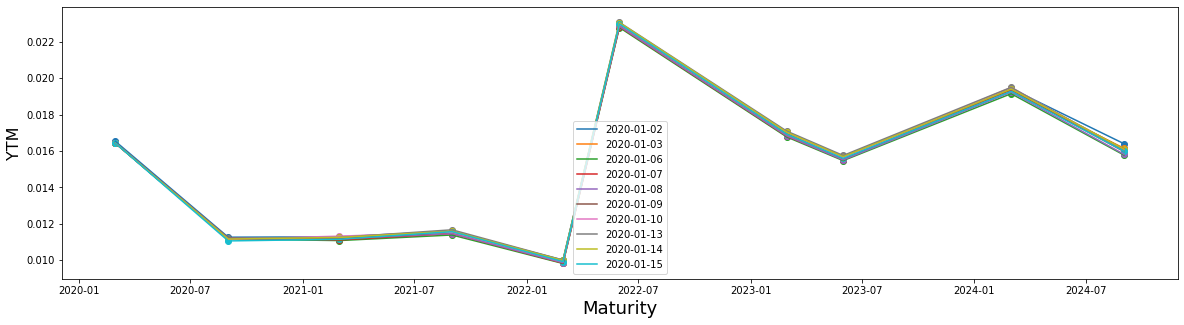

In [9]:
# ytm curve
cdate = curve_dates[0]
plt.figure(figsize=(20,5))
plt.xlabel('Maturity', fontsize=18)
plt.ylabel('YTM', fontsize=16)
ytm_matrix = np.zeros((10,10))
for j,cdate in enumerate(curve_dates):
    jan_prices = bonds.loc[cdate].sort_values('Maturity')
    yields = []
    for i in range(10):
        row = jan_prices.iloc[i]
        price = row['Close']
        coupon = row['Coupon']/100.0*PAR
        maturity = row['Maturity']
        yields.append(get_yield(price,coupon, i+1))
        
    x,y = list(jan_prices['Maturity']),list(yields)
    ytm_matrix[:,j] = y
    plt.plot(x,y, label=cdate.date())
    plt.scatter(x,y)
    #print(yields)
plt.legend()

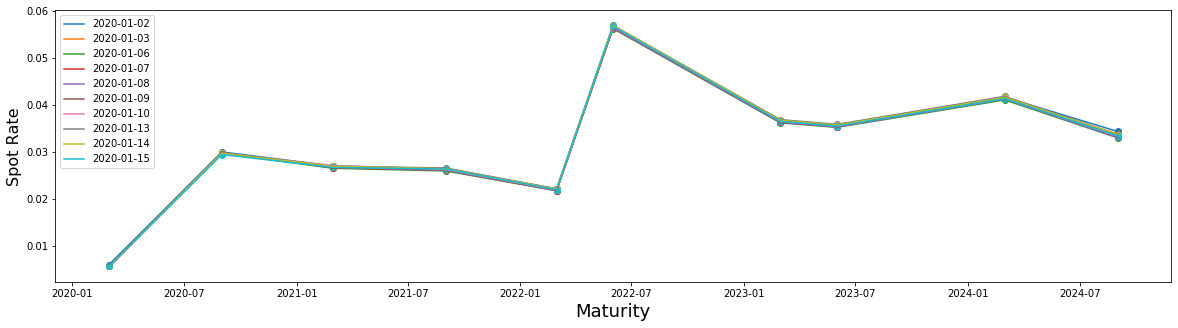

In [10]:
# spot rates
plt.figure(figsize=(20,5))
plt.xlabel('Maturity', fontsize=18)
plt.ylabel('Spot Rate', fontsize=16)
spot_matrix = np.zeros((10,10))
for i,cdate in enumerate(curve_dates):
    jan_prices = bonds.loc[cdate].sort_values('Maturity')
    spot_rates = get_spot_rate(jan_prices['Close'],jan_prices['Coupon'])
    
    x,y = list(jan_prices['Maturity']), spot_rates
    plt.plot(x,y, label=cdate.date())
    plt.scatter(x,y)
    
    spot_matrix[:,i] = spot_rates
plt.legend()

In [11]:
# interpolate spot rates
interpolated_spot_matrix = np.zeros((5,10))
interpolated_spot_matrix[0,:] = spot_matrix[1,:]/2 + spot_matrix[2,:]/2
interpolated_spot_matrix[1,:] = spot_matrix[3,:]/2 + spot_matrix[4,:]/2
interpolated_spot_matrix[2,:] = spot_matrix[5,:]/3 + spot_matrix[6,:]*2/3
interpolated_spot_matrix[3,:] = spot_matrix[7,:]/3 + spot_matrix[8,:]*2/3
interpolated_spot_matrix[4,:] = spot_matrix[9,:]

# interpolate ytm
interpolated_ytm_matrix = np.zeros((5,10))
interpolated_ytm_matrix[0,:] = ytm_matrix[1,:]/2 + ytm_matrix[2,:]/2
interpolated_ytm_matrix[1,:] = ytm_matrix[3,:]/2 + ytm_matrix[4,:]/2
interpolated_ytm_matrix[2,:] = ytm_matrix[5,:]/3 + ytm_matrix[6,:]*2/3
interpolated_ytm_matrix[3,:] = ytm_matrix[7,:]/3 + ytm_matrix[8,:]*2/3
interpolated_ytm_matrix[4,:] = ytm_matrix[9,:]

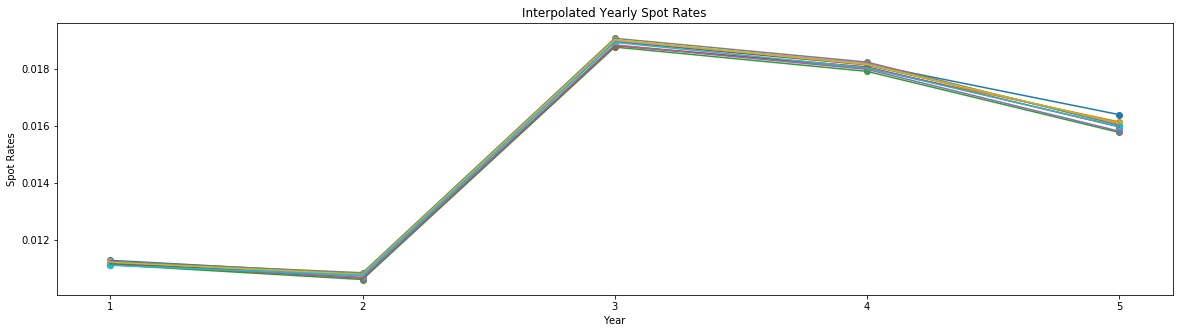

In [16]:
plt.figure(figsize=(20,5))
plt.title('Interpolated Yearly Spot Rates')
plt.xlabel('Year')
plt.ylabel('Spot Rates')
for i in range(10):
    plt.plot(interpolated_ytm_matrix[:,i])
    plt.scatter(['1','2','3','4','5'],interpolated_ytm_matrix[:,i])

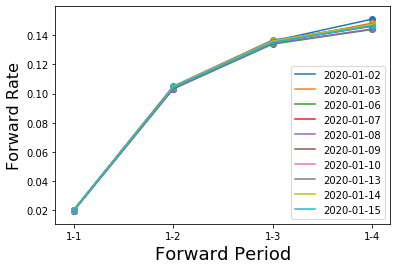

In [12]:
# Forward rates from spot rates
forward_rates = np.zeros((4,10)) # number of forward rates x number of days
plt.figure()
plt.xlabel('Forward Period', fontsize=18)
plt.ylabel('Forward Rate', fontsize=16)
x = ['1-1','1-2','1-3','1-4']
for i in range(1,5): # 1-1,1-2,1-3,1-4 rates
    forward_rates[i-1,:] = (1+interpolated_spot_matrix[i,:])**(i+1)/(1+interpolated_spot_matrix[0,:])-1

for i in range(10): # plot for each day
    plt.plot(x,forward_rates[:,i],label=curve_dates[i].date())
    plt.scatter(x,forward_rates[:,i])
plt.legend()

In [13]:
# Question 5
shift = np.roll(interpolated_ytm_matrix, -1, axis=1) # shift left
log_ret = np.log((shift/interpolated_ytm_matrix)[:,0:8]) # first 9 ratios
cov_ytm = np.cov(log_ret)
cor_ytm = np.corrcoef(log_ret)

shift = np.roll(forward_rates, -1, axis=1) # shift left
log_ret = np.log((shift/forward_rates)[:,0:8]) # first 9 ratios
cov_foward = np.cov(log_ret)
cor_forward = np.corrcoef(log_ret)

print(cov_ytm)
print(cor_ytm)
print(cov_foward)
print(cor_forward)

[[2.53868759e-05 2.18213531e-05 1.76422865e-05 2.33948236e-05
  3.40055424e-05]
 [2.18213531e-05 5.35110232e-05 3.25962705e-05 4.03727655e-05
  6.99607817e-05]
 [1.76422865e-05 3.25962705e-05 2.23638377e-05 2.79347979e-05
  4.86269471e-05]
 [2.33948236e-05 4.03727655e-05 2.79347979e-05 4.50390544e-05
  7.68121346e-05]
 [3.40055424e-05 6.99607817e-05 4.86269471e-05 7.68121346e-05
  1.92049397e-04]]
[[1.         0.59204595 0.74041818 0.69186365 0.48701081]
 [0.59204595 1.         0.94226513 0.82237943 0.69012308]
 [0.74041818 0.94226513 1.         0.88019265 0.74198883]
 [0.69186365 0.82237943 0.88019265 1.         0.8259024 ]
 [0.48701081 0.69012308 0.74198883 0.8259024  1.        ]]
[[2.10740272e-04 6.39984963e-05 7.76563245e-05 1.53964813e-04]
 [6.39984963e-05 2.58515895e-05 3.34942851e-05 6.52577985e-05]
 [7.76563245e-05 3.34942851e-05 6.23913614e-05 1.13992190e-04]
 [1.53964813e-04 6.52577985e-05 1.13992190e-04 3.15958270e-04]]
[[1.         0.86706644 0.67723724 0.59666814]
 [0.8670

In [14]:
# Question 6
print(np.linalg.eig(cov_ytm))
print(np.linalg.eig(cov_foward))

(array([2.82193600e-04, 3.63084317e-05, 1.35920745e-05, 5.36305833e-06,
       8.93023932e-07]), array([[-0.18698806, -0.42155   ,  0.78285268, -0.3608688 , -0.21034841],
       [-0.36225798, -0.55732173, -0.59435215, -0.22002558, -0.39559565],
       [-0.24710844, -0.34190307, -0.06959529, -0.14376399,  0.89248424],
       [-0.36781941, -0.25428741,  0.16764612,  0.8774571 , -0.0448398 ],
       [-0.79840524,  0.57456792,  0.03063456, -0.17539499, -0.02681235]]))
(array([4.92308224e-04, 1.02739814e-04, 1.67889232e-05, 3.10453198e-06]), array([[ 5.43571338e-01,  7.91784962e-01, -2.14075242e-01,
         1.78265435e-01],
       [ 2.02277131e-01,  1.38502591e-01,  2.44712710e-01,
        -9.38092045e-01],
       [ 3.13326210e-01, -3.83120908e-02,  9.01195978e-01,
         2.96992726e-01],
       [ 7.51958010e-01, -5.93654605e-01, -2.86589060e-01,
        -2.67326578e-04]]))
